In [49]:
!nvidia-smi

Tue Sep  7 07:36:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    61W / 149W |    763MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Convolutional Neural Network 구현
- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교.

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import matplotlib.pyplot as plt
# 학습결과 그래프 함수
# loss 그래프
def plot_loss(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [52]:
# accuracy 그래프
def plot_accuracy(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# MNIST CNN 적용

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

In [54]:
# random seed 설정

np.random.seed(0)
tf.random.set_seed(0)

## data loading

In [55]:
(train_img, train_label), (test_img, test_label) = keras.datasets.mnist.load_data()
train_img.shape, test_img.shape

((60000, 28, 28), (10000, 28, 28))

## 하이퍼파라미터, 변수 설정

In [56]:
LEARNING_RATE = 0.001
N_EPOCHS = 20
N_BATCHS = 100

N_TRAIN = train_img.shape[0]
N_TEST = test_img.shape[0]

## 전처리, Dataset 생성
- X: 0~1 scaling
    - gray scale일 경우 channel 축을 늘려줘야 한다
- y: one hot encoding

In [57]:
# 0~1 scaling
X_train_tmp = (train_img/255.0).astype(np.float32)
X_test_tmp = (test_img/255.0).astype(np.float32)

# channel 축을 추가
X_train = X_train_tmp[..., np.newaxis]
X_test = X_test_tmp[..., np.newaxis]

In [58]:
y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [59]:
# Dataset 생성
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

## model(network) 정의
- feature extraction: Convolution layer 사용
    - block: convolution + MaxPooling layer
    - size(height, width)는 줄이고 channel은 늘리는 방향으로 layer들을 쌓는다.
    - convolution
        - size: 3*3
        - strides: 1
    - MaxPooling
        - size: 2*2
        - strides: 2

- 분류기
    - Dense layer 사용
    - Flatten을 먼저 해야 한다. (conv의 output-feature map이 3차원 배열이기 때문)
      

In [60]:
def create_mnist_model():
  model = keras.Sequential()
  # input layer - Convolution layer의 input shape은 반드시 3차원으로 지정해야 한다. (height, width, channel)
  model.add(layers.InputLayer((28, 28, 1)))   # gray scale은 channel을 1로 지정

  # convolution block
  # conv layer: layers.Conv2D(filters=필터(kernel) 개수, kernel_size=filter의 shape(height, width가 같은 경우 하나만 써도 됨), padding=패딩 방식, strides=이동 간격(default가 (1,1), activation))
  model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'))
  
  # max pooling layer: MaxPoolg2D() - feature map의 size를 줄여주는 역할
  model.add(layers.MaxPool2D(pool_size=(2,2),  # size (height, width) - height와 width가 같은 경우에는 하나만 써줘도 된다.(default=(2,2))
                           strides=(2,2),  # 이동 간격(상하, 좌우) - 동일할 경우 하나만 써도 된다.(default: pool_size)
                           padding='same'  # 'same'(전체 input 모두 사용), 'valid'(마지막에 남는 영역은 버린다.) -> 보통 same으로 준다.
                           ))

  model.add(layers.Conv2D(filters=64,  # filter의 개수는 늘린다. == channel의 size는 늘린다.
                          kernel_size=3,  # (3,3)임. -> 같은경우 정수 하나만 줘도 됨,
                          # strides는 생략. default: 1
                          padding='same',  # default: vaild라서 same으로 지정
                          activation = 'relu'
                          ))
  model.add(layers.MaxPool2D(padding='same'))  # pool_size, strides 생략: 기본값 (2,2)
  model.add(layers.Conv2D(filters=128, kernel_size = 3, padding = 'same', activation='relu'))
  model.add(layers.MaxPool2D(padding='same'))

  ### --- Dense Layer 추가 ###
  # Flatten Layer 추가 : 3차원 -> 1차원
  model.add(layers.Flatten())
  model.add(layers.Dense(units=256, activation='relu'))  # Dense 레이어로 Hidden 추가.
  
  ### 출력 ###
  # 다중분류 출력 레이어 (10가지 클래스)
  model.add(layers.Dense(units=10, activation='softmax'))
  return model

In [61]:
model = create_mnist_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)             

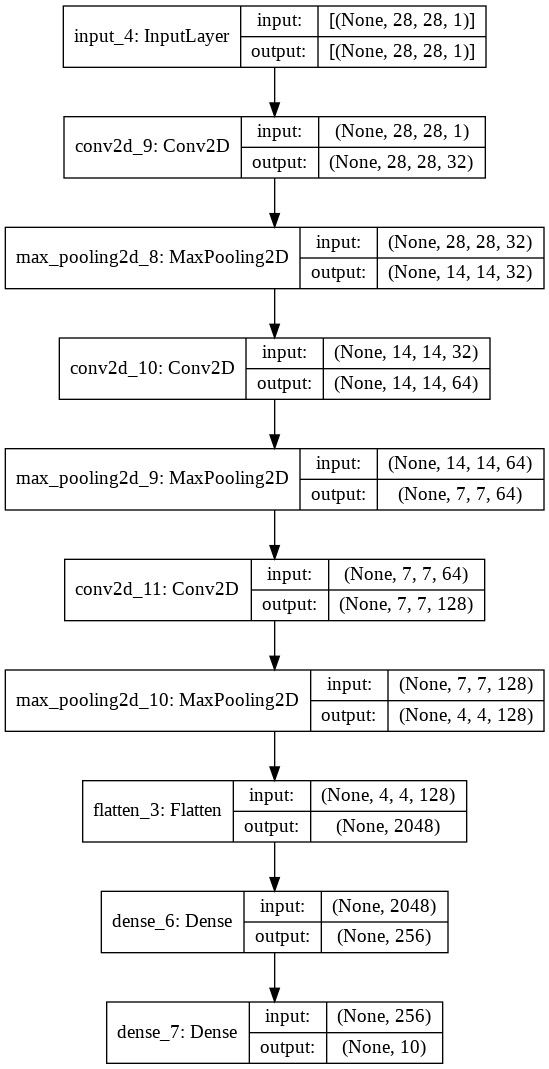

In [62]:
keras.utils.plot_model(model, show_shapes=True)

In [63]:
hist = model.fit(train_dataset, epochs=N_EPOCHS, validation_data=test_dataset)

Epoch 1/20
600/600 [==============================] - 8s 12ms/step - loss: 0.1620 - accuracy: 0.9502 - val_loss: 0.0438 - val_accuracy: 0.9846
Epoch 2/20
600/600 [==============================] - 7s 12ms/step - loss: 0.0455 - accuracy: 0.9859 - val_loss: 0.0419 - val_accuracy: 0.9855
Epoch 3/20
600/600 [==============================] - 7s 11ms/step - loss: 0.0307 - accuracy: 0.9906 - val_loss: 0.0312 - val_accuracy: 0.9889
Epoch 4/20
600/600 [==============================] - 7s 12ms/step - loss: 0.0233 - accuracy: 0.9926 - val_loss: 0.0244 - val_accuracy: 0.9917
Epoch 5/20
600/600 [==============================] - 7s 11ms/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 0.0278 - val_accuracy: 0.9917
Epoch 6/20
600/600 [==============================] - 7s 11ms/step - loss: 0.0159 - accuracy: 0.9949 - val_loss: 0.0218 - val_accuracy: 0.9931
Epoch 7/20
600/600 [==============================] - 7s 11ms/step - loss: 0.0127 - accuracy: 0.9957 - val_loss: 0.0262 - val_accuracy: 0.9919

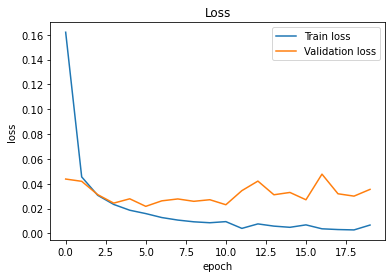

In [64]:
plot_loss(hist)

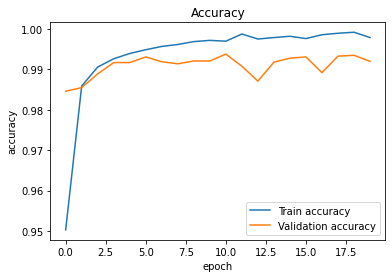

In [65]:
plot_accuracy(hist)

In [66]:
# 최종 검증
loss, acc = model.evaluate(test_dataset)

100/100 [==============================] - 1s 5ms/step - loss: 0.0354 - accuracy: 0.9920


In [67]:
print(loss, acc)

0.03543037548661232 0.9919999837875366


### prediction error가 발생한 example 확인

In [68]:
y = np.array([1,2,3,4,5,6])
p = np.array([1,2,6,4,5,1])
np.where(y!=p)

(array([2, 5]),)

In [69]:
r = np.where(y!=p)[0]
p[r], y[r]

(array([6, 1]), array([3, 6]))

In [70]:
pred = model.predict(X_test)
pred.shape

(10000, 10)

In [71]:
pred[0]

array([2.1325591e-18, 7.8748457e-14, 4.0330817e-16, 2.5709783e-11,
       2.9483849e-10, 5.8360587e-18, 2.6400448e-20, 1.0000000e+00,
       4.9855131e-16, 6.8849709e-10], dtype=float32)

In [72]:
np.argmax(pred[0], axis=-1)

7

In [73]:
pred_label = np.argmax(pred, axis=-1)
pred_label.shape

(10000,)

In [74]:
pred_label[:5]

array([7, 2, 1, 0, 4])

In [75]:
test_label[:5]

array([7, 2, 1, 0, 4], dtype=uint8)

In [76]:
np.where(test_label != pred_label)

(array([  43,  247,  321,  326,  445,  449,  582,  583,  625,  646,  659,
         882,  938,  947, 1014, 1182, 1226, 1232, 1260, 1319, 1393, 1527,
        1559, 1709, 1878, 1901, 1982, 2098, 2129, 2130, 2135, 2182, 2414,
        2437, 2447, 2597, 2654, 2771, 2896, 2939, 2953, 2959, 2995, 3023,
        3062, 3225, 3250, 3422, 3520, 3558, 3597, 3762, 3926, 4001, 4078,
        4176, 4284, 4289, 4380, 4504, 4536, 4571, 4740, 4761, 4823, 4838,
        4860, 5937, 6571, 6576, 6597, 6625, 6785, 7216, 8310, 8408, 9642,
        9664, 9679, 9692]),)

In [77]:
idx = np.where(test_label != pred_label)[0]
idx.shape

(80,)

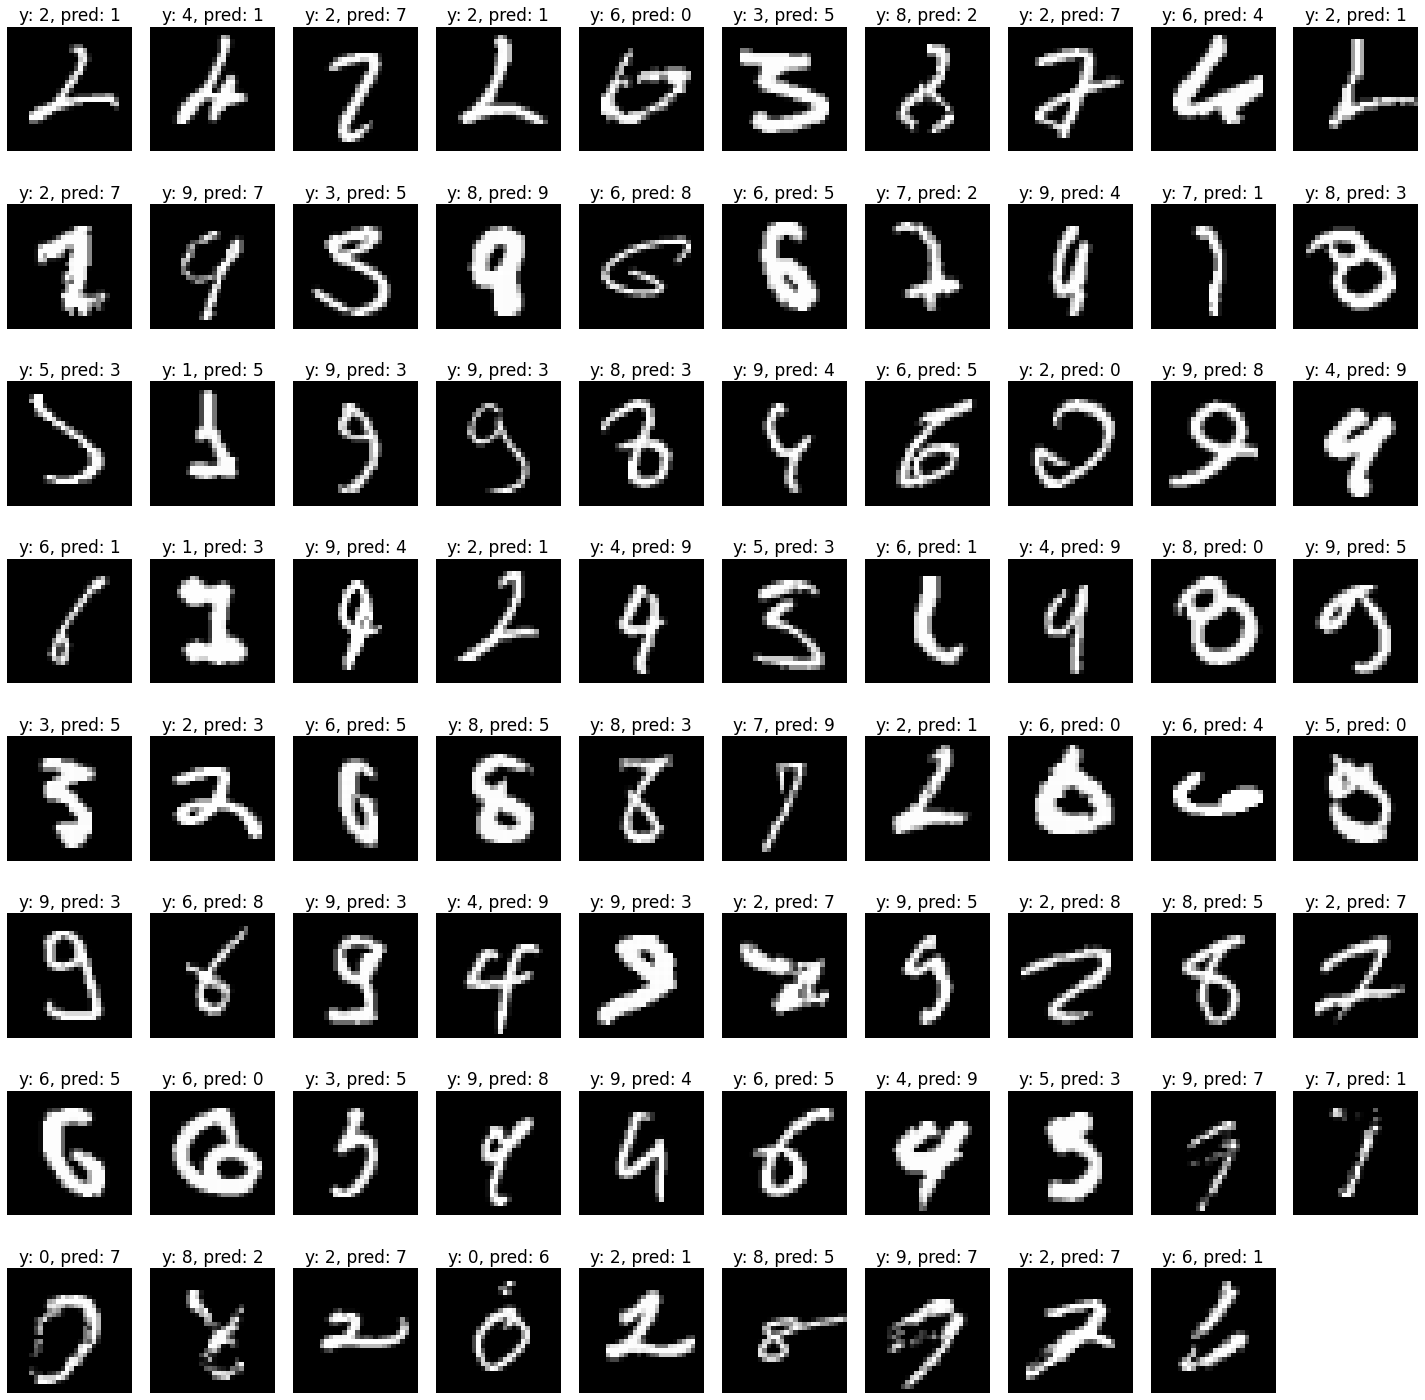

In [78]:
# 틀린 결과 중 10개 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
for i in range(79):
  error_idx = idx[i]
  p = pred_label[error_idx]  # 예측
  y = test_label[error_idx]  # 정답

  plt.subplot(8, 10, i+1)
  plt.imshow(test_img[error_idx], cmap='gray')
  plt.title('y: {}, pred: {}'.format(y, p), fontsize=17)
  plt.axis('off')

plt.tight_layout()
plt.show()

# 모델 저장
1. 학습이 끝난 모델의 파라미터만 저장
1. 모델 전체 저장
1. Callback 함수를 이용해 학습시 가장 좋은 지표의 모델 저장

## 텐서플로 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 파일타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 형식

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장: `model.save_weights("저장경로")`
- 불러오기: `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`

In [79]:
import os

base_dir = '/content/drive/MyDrive/202105_lab'
mnist_weight_dir = os.path.join(base_dir, 'mnist_weight')   # 가중치를 저장할 경로(디렉토리)
print(mnist_weight_dir)

# directory 생성
if not os.path.isdir(mnist_weight_dir):   # 디렉토리가 있는지 여부 확인
  os.mkdir(mnist_weight_dir)   # 디렉토리 생성

/content/drive/MyDrive/202105_lab/mnist_weight


In [80]:
weight_file_path = os.path.join(mnist_weight_dir, 'mnist_weight.ckpt')   # 가중치 파일 저장 경로
print(weight_file_path)

/content/drive/MyDrive/202105_lab/mnist_weight/mnist_weight.ckpt


In [85]:
model.save_weights(weight_file_path)  # weight_file_path 경로에 학습된 파라미터(가중치)를 저장

In [82]:
# 저장된 weight를 불러오기
# 모델을 생성한 뒤 저장된 weight를 덮어 씌우는 형식

new_model = create_mnist_model()
new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
new_model.evaluate(test_dataset)   # 학습이 안 된 모델

100/100 [==============================] - 1s 6ms/step - loss: 2.3066 - accuracy: 0.0980


[2.306602716445923, 0.09799999743700027]

In [86]:
# 저장된 weight를 새로운 모델에 덮어 씌우기
new_model.load_weights(weight_file_path)

In [87]:
new_model.evaluate(test_dataset)

100/100 [==============================] - 1s 6ms/step - loss: 0.0354 - accuracy: 0.9920


[0.03543037548661232, 0.9919999837875366]

## 전체 모델 저장하고 불러오기
- 저장: `model.save('저장할디렉토리')`
- 불러오기: `tf.keras.models.load_model('저장디렉토리경로')`
- 저장 형식
    - Tensorflow SavedModel 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 로 지정한다.
    

In [88]:
mnist_model_dir = os.path.join(base_dir, 'mnist_model')
print(mnist_model_dir)
if not os.path.isdir(mnist_model_dir):
  os.mkdir(mnist_model_dir)

/content/drive/MyDrive/202105_lab/mnist_model


In [89]:
model.save(mnist_model_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/202105_lab/mnist_model/assets


In [90]:
# 불러오기
new_model2 = keras.models.load_model(mnist_model_dir)

In [91]:
new_model2.evaluate(test_dataset)

100/100 [==============================] - 1s 6ms/step - loss: 0.0354 - accuracy: 0.9920


[0.03543037548661232, 0.9919999837875366]

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공된다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- `EarlyStopping`: Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈춤
    - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
    - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다. 
- `ModelCheckpoint`: 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight를 저장하여 overfitting이 발생하기 전의 model을 나중에 불러들여 사용할 수 있음
    - `save_best_only=True`: monitoring 중인 measure를 기준으로 성능 지표가 개선된 weight/모델을 저장 
    - verbose=2: 저장 로그를 남김
- **callback 객체들을 리스트로 묶은 뒤 fit()의 callback 매개변수에 전달한다.**

In [93]:
model2 = create_mnist_model()
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [94]:
cp_save_dir = os.path.join(base_dir, 'mnist_callback')
if not os.path.isdir(cp_save_dir):
  os.mkdir(cp_save_dir)

In [95]:
# callback 생성
# ModelCheckpoint - 모델 저장 callback

cp_save_file = os.path.join(cp_save_dir, 'saved_model_{epoch:04d}.ckpt')   # {epoch:04d} 몇 번째 에폭인지 파일명에 들어감
print(cp_save_file)
mc_callback = keras.callbacks.ModelCheckpoint(filepath=cp_save_file, save_weights_only=True, save_best_only=True, monitor='val_loss', verbose=2)

/content/drive/MyDrive/202105_lab/mnist_callback/saved_model_{epoch:04d}.ckpt


In [96]:
# EarlyStopping callback - 성능 개선이 없으면 전체 epoch 다 반복하지 않고 중간에 멈춰주는 callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [97]:
hist = model2.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[mc_callback, es_callback])

Epoch 1/100
600/600 [==============================] - 8s 12ms/step - loss: 0.1593 - accuracy: 0.9504 - val_loss: 0.0373 - val_accuracy: 0.9871

Epoch 00001: val_loss improved from inf to 0.03735, saving model to /content/drive/MyDrive/202105_lab/mnist_callback/saved_model_0001.ckpt
Epoch 2/100
600/600 [==============================] - 7s 11ms/step - loss: 0.0415 - accuracy: 0.9871 - val_loss: 0.0292 - val_accuracy: 0.9903

Epoch 00002: val_loss improved from 0.03735 to 0.02918, saving model to /content/drive/MyDrive/202105_lab/mnist_callback/saved_model_0002.ckpt
Epoch 3/100
600/600 [==============================] - 7s 11ms/step - loss: 0.0285 - accuracy: 0.9910 - val_loss: 0.0339 - val_accuracy: 0.9896

Epoch 00003: val_loss did not improve from 0.02918
Epoch 4/100
600/600 [==============================] - 7s 12ms/step - loss: 0.0218 - accuracy: 0.9927 - val_loss: 0.0271 - val_accuracy: 0.9907

Epoch 00004: val_loss improved from 0.02918 to 0.02708, saving model to /content/drive/

In [102]:
new_model4 = create_mnist_model()
new_model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

new_model4.load_weights("/content/drive/MyDrive/202105_lab/mnist_callback/saved_model_0005.ckpt")

In [104]:
new_model4.evaluate(test_dataset)

100/100 [==============================] - 1s 6ms/step - loss: 0.0258 - accuracy: 0.9918


[0.025815140455961227, 0.9918000102043152]